## Eng+Wales well-mixed example model 

This is the Fisher Information Matrix (FIM) notebook.  There are various model variants as encoded by `expt_params_local` and `model_local`, which are shared by the notebooks in a given directory.

Outputs of this notebook:
* `ewMod-FIM.npy` : FIM (matrix as numpy array)
* `ewMod-FIM-evec.pik` : eigenvector corresponding to soft mode

**Note :** there are two soft modes of the FIM with very small eigenvalues, these are almost degenerate.  As a result, the computed eigenvector can differ according to libraries used and settings including OMP_NUM_THREADS.  The eigenvector that we save (and later plot) represents a soft mode, but it should be borne in mind that it is not unique.


### Start notebook
(the following line is for efficient parallel processing)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import pandas as pd
import matplotlib.image as mpimg
import pickle
import os
import pprint

from scipy.linalg import eigh
from scipy.misc import derivative

import scipy.stats
import matplotlib.ticker

plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)

In [3]:
#print(pyross.__file__)
#print(os.getcwd())

In [4]:
from ew_fns import *
import expt_params_local
import model_local

### switches etc

In [5]:
verboseMod=False    ## print ancillary info about the model?

## Calculate things, or load from files ?
## NOTE : if we do inference and not Hessian then info in saved files can get out of sync...
doFIM = False
diagFIM = False

## time unit is one week
daysPerWeek = 7.0

## these are params that might be varied in different expts
exptParams = expt_params_local.getLocalParams() 

pprint.pprint(exptParams)

## this is used for filename handling throughout
pikFileRoot = exptParams['pikFileRoot']

{'careFile': '../data/CareHomes.csv',
 'chooseCM': 'fumanelliEtAl',
 'dataFile': '../data/OnsData.csv',
 'estimatorTol': 1e-08,
 'exCare': True,
 'forecastTime': 3,
 'freeInitPriors': ['E', 'A', 'Is1', 'Is2', 'Is3'],
 'infOptions': {'cma_population': 32,
                'cma_processes': None,
                'ftol': 5e-05,
                'global_atol': 1.0,
                'global_max_iter': 1500,
                'local_max_iter': 400},
 'inferBetaNotAi': True,
 'numCohorts': 16,
 'numCohortsPopData': 19,
 'pikFileRoot': 'ewMod',
 'popFile': '../data/EWAgeDistributedNew.csv',
 'timeLast': 8,
 'timeZero': 0}


### convenient settings

In [6]:
np.set_printoptions(precision=3) 
pltAuto = True
plt.rcParams.update({'figure.autolayout': pltAuto})
plt.rcParams.update({'font.size': 14})

## LOAD MODEL

In [7]:
loadModel = model_local.loadModel(exptParams,daysPerWeek,verboseMod) 

## this is a bit of a hack but...
[ numCohorts, fi, N, Ni, model_spec, estimator, contactBasis, interventionFn,
   modParams, priorsAll, initPriorsLinMode, obsDeath, fltrDeath, 
   simTime, deathCumulativeDat ] = loadModel

** model

{'A': {'infection': [], 'linear': [['E', 'gammaE'], ['A', '-gammaA']]},
 'E': {'infection': [['A', 'beta'],
                     ['Is1', 'beta'],
                     ['Is2', 'betaLate'],
                     ['Is3', 'betaLate']],
       'linear': [['E', '-gammaE']]},
 'Im': {'infection': [], 'linear': [['Is3', 'cfr*gammaIs3']]},
 'Is1': {'infection': [],
         'linear': [['A', 'gammaA'],
                    ['Is1', '-alphabar*gammaIs1'],
                    ['Is1', '-alpha*gammaIs1']]},
 'Is2': {'infection': [],
         'linear': [['Is1', 'alphabar*gammaIs1'], ['Is2', '-gammaIs2']]},
 'Is3': {'infection': [],
         'linear': [['Is2', 'gammaIs2'],
                    ['Is3', '-cfrbar*gammaIs3'],
                    ['Is3', '-cfr*gammaIs3']]},
 'S': {'infection': [['A', '-beta'],
                     ['Is1', '-beta'],
                     ['Is2', '-betaLate'],
                     ['Is3', '-betaLate']],
       'linear': []},
 'classes': ['S', 'E', 'A', 'Is1', 'Is2', 'Is

### Load inference result

In [8]:
ipFile = pikFileRoot + "-inf.pik"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    [infResult,elapsedInf] = pickle.load(f)
print('** read infResult',elapsedInf/60,'minute calc')

ipf ewMod-inf.pik
** read infResult 8.487578407923381 minute calc


### Compute/load the Fisher information matrix

In [9]:
if doFIM:
    
    ## this eps amounts to a perturbation of approx 1% on each param
    xx = infResult['flat_params']
    fx = abs(infResult['log_likelihood'])
    eps = 100 * xx * (np.spacing(fx)/fx)**(0.25) 
    
    print('**params\n',infResult['flat_params'])
    print('** rel eps\n',eps/infResult['flat_params']) 
    
    epiParamsMAP = infResult['params_dict']
    conParamsMAP = infResult['control_params_dict']
    
    CM_MAP = contactBasis.intervention_custom_temporal( interventionFn, 
                                                        **conParamsMAP)
    estimator.set_params(epiParamsMAP)
    estimator.set_contact_matrix(CM_MAP)
        
    start = time.time()
    FIM = estimator.latent_FIM(obs=obsDeath,
                              fltr=fltrDeath,
                              Tf=simTime,
                              generator=contactBasis,
                              infer_result=infResult,
                              intervention_fun=interventionFn,
                              tangent=False,
                              eps=eps,
                              inter_steps=100)
    end = time.time()
    print('time',(end-start)/60,'mins')
    
    opFile = pikFileRoot + "-FIM.npy"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        np.save(f,FIM)

else : 
    print('Load FIM')

# reload in all cases (even if we just saved it)
ipFile = pikFileRoot + "-FIM.npy"
try:
    print('ipf',ipFile)
    with open(ipFile, 'rb') as f: 
        FIM = np.load(f)
except (OSError, IOError) : 
    print('... error loading FIM')
    FIM = None

Load FIM
ipf ewMod-FIM.npy


### diagonalise the FIM (or load the spectrum)

In [10]:
## inferred parameter indices
No = np.arange(0, len(infResult['flat_params']))

evals,evecs = 0,0

if diagFIM :
    print('diagonalising FIM')
    evals, evecs = scipy.linalg.eigh(FIM)

    opFile = pikFileRoot + "-FIM-evec.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f:
        pickle.dump([evals, evecs],f)

else :
    print('loading FIM spectrum')

    ipFile = pikFileRoot + "-FIM-evec.pik"
    with open(ipFile, 'rb') as f:
        [evals, evecs] = pickle.load(f)

print('evals',evals)

## sensitivities
sens = np.sqrt(np.diagonal(FIM))*infResult['flat_params']

loading FIM spectrum
evals [-9.346e-07  3.751e-05  1.550e-03  1.768e-02  5.274e-02  1.165e+00
  2.155e+00  2.302e+00  2.486e+00  2.907e+00  6.238e+00  8.166e+00
  1.473e+01  2.067e+01  2.858e+01  4.253e+01  5.294e+01  7.575e+01
  8.178e+01  1.021e+02  1.502e+02  1.806e+02  1.824e+02  2.021e+02
  2.468e+02  2.584e+02  2.989e+02  3.432e+02  5.523e+02  6.447e+02
  8.188e+02  8.350e+02  9.553e+02  1.281e+03  1.770e+03  2.459e+03
  3.061e+03  3.752e+03  6.681e+03  2.505e+04  3.229e+05  2.956e+07
  7.002e+08  6.525e+09  4.178e+11  8.709e+11]


## at this point all computation is done

there follow some example plots which are similar to those in the manuscript

### Plots: Sensitivity

In [11]:
## indices
betas_ = np.s_[0:16]
#betaL_ = 16
gammas_ = np.s_[16:22] # include betaLate with gammas
aF_ = np.s_[22:38]
lock_ = np.s_[38:40]
inits_ = np.s_[40:46]

In [12]:
## cohort age ranges
cohRanges = [ [x,x+4] for x in range(0,75,5) ]
cohLabs = ["{l:d}-{u:d}".format(l=low,u=up) for [low,up] in cohRanges ]
cohLabs.append("75+")

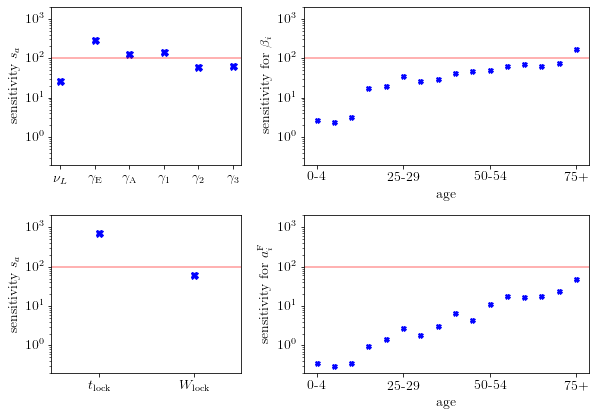

In [13]:
fig,axs = plt.subplots(2,2,figsize=(8.5,6),sharey=True,gridspec_kw={'width_ratios': [1,1.5]})
plt.subplots_adjust(wspace=0.35,right=0.97,left=0.11,bottom=0.13,top=0.97,hspace=0.5)

plotLabs_g = ['$\\nu_{L}$',
            '$\\gamma_{\\rm E}$','$\\gamma_{\\rm A}$',
            '$\\gamma_{1}$','$\\gamma_{2}$','$\\gamma_{3}$']

row,col = 0,0
ax = axs[row,col]

ax.set_yscale('log')
ax.set_ylim(0.2, 2000)
ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=15))
bigNum = 12  ## arbitrary big number
tickSetup = matplotlib.ticker.LogLocator(base=10.0,
                                         subs=[0.1*(1+x) for x in range(9)],
                                         numticks=bigNum)
ax.yaxis.set_minor_locator(tickSetup)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xticks(No[gammas_])
ax.set_xticklabels(plotLabs_g)
ax.set_ylabel('sensitivity $s_a$', labelpad=6)
ax.plot(No[gammas_], sens[gammas_], 'X', c='blue', markersize=7)
ax.axhline(y=1e2, color='red', alpha=0.3, lw=2)

row,col = 1,0
ax = axs[row,col]

plotLabs = ['$t_{\\rm lock}$',
           '$W_{\\rm lock}$']

ax.set_xticks(No[lock_])
ax.set_xticklabels(plotLabs)
ax.set_ylabel('sensitivity $s_a$', labelpad=6)

ax.plot(No[lock_], sens[lock_], 'X', c='blue', markersize=7)
ax.axhline(y=1e2, color='red', alpha=0.3, lw=2)

ax.set_xlim(No[lock_][0]-0.5,No[lock_][-1]+0.5)


## sensitivity for betas
yesTick = [0,5,10,15] # [0,4,8,12,15]

row,col = 0,1
ax = axs[row,col]

ax.set_ylabel('sensitivity for $\\beta_{i}$', labelpad=6)
ax.tick_params(labelleft=True)

ax.set_xticks(yesTick)
ax.set_xticklabels([cohLabs[ii] for ii in yesTick])

ax.plot(No[betas_], sens[betas_], 'X', c='blue', markersize=5)
ax.axhline(y=1e2, color='red', alpha=0.3, lw=2)
#ax.ylim(bottom=1, top=300)
ax.set_xlabel('age')
#plt.show(); plt.close()

## sensitivity for aF

row,col = 1,1
ax = axs[row,col]

ax.set_ylabel('sensitivity for $a^{\\rm F}_{i}$', labelpad=6)
ax.tick_params(labelleft=True)
ax.tick_params(labelbottom=True)

aTick = [ yy+No[aF_][0] for yy in yesTick ]

ax.set_xticks(aTick)
ax.set_xticklabels([cohLabs[ii] for ii in yesTick])

ax.plot(No[aF_], sens[aF_], 'X', c='blue', markersize=5)
ax.axhline(y=1e2, color='red', alpha=0.3, lw=2)
#ax.ylim(bottom=1, top=300)
ax.set_xlabel('age')
plt.show(); plt.close()

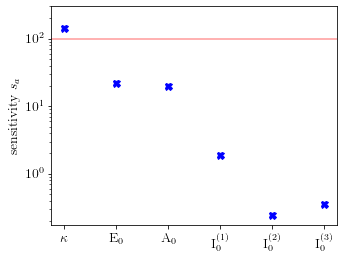

In [14]:
## sensitivity for inits
fig, ax = plt.subplots(1,1,figsize=(5, 3.8))
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.15,top=0.97)

plotLabs = ['$\\kappa$',
            '${\\rm E}_{0}$',
            '${\\rm A}_{0}$',
            '${\\rm I}_{0}^{(1)}$',
            '${\\rm I}_{0}^{(2)}$',
            '${\\rm I}_{0}^{(3)}$']

ax.set_xticks(No[inits_])
ax.set_xticklabels(plotLabs)
ax.set_ylabel('sensitivity $s_a$',labelpad=6)

ax.semilogy(No[inits_], sens[inits_], 'X', c='blue', markersize=7)
ax.set_ylim(top=300.)
#ax.set_xlim(37.5, 40.5)
ax.axhline(y=1e2, color='red', alpha=0.3, lw=2)
plt.show(); plt.close()

### Plots: Soft mode

[21 20 19 18 28 25]


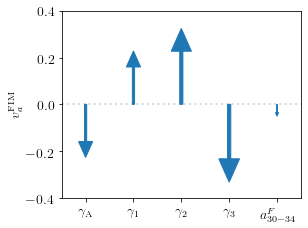

In [15]:
## second eigenvalue
maps = infResult['flat_params']

evec_soft = evecs[:,1].copy()/maps

#print('maps\n',maps)
#print('evals\n',evals)
#print('evec\n',evec_soft)

sortOrder = np.flip( np.argsort(np.abs(evec_soft[:40])) )
print(sortOrder[:6])

softgA   = evec_soft[18]
softgI1  = evec_soft[19]
softgI2  = evec_soft[20]
softgI3  = evec_soft[21]
softaF   = evec_soft[28] ## for age 30-34

params_soft = [softgA,softgI1,softgI2,softgI3,softaF]

fig, ax = plt.subplots(1,1,figsize=(4.5,3.4))
plt.subplots_adjust(left=0.27,bottom=0.13,top=0.97,right=0.97)

plotLabs_soft = ['$\\gamma_{\\rm A}$',
                '$\\gamma_{1}$','$\\gamma_{2}$',
                '$\\gamma_{3}$',
                '$a^{F}_{30-34}$']

ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(plotLabs_soft)

#ax.set_yticks([])
ax.set_ylabel('$v^{\\rm FIM}_a$')

for ii,pp in enumerate(params_soft) :
    ax.arrow( ii+1,0,0,pp,width=0.2*np.abs(pp),
             head_width=1.3*np.abs(pp), length_includes_head=True,
             head_length=0.3*np.abs(pp), ec='C0' )


ax.axhline(y=0, color='grey', alpha=0.3, lw=2, linestyle='dotted')

maxPos = np.max(params_soft)
maxModNeg = -np.min(params_soft)
maxMod = np.maximum(maxPos,maxModNeg)
maxMod *= 1.2

ax.set_xlim(0.5,len(params_soft)+0.5)
ax.set_ylim(-maxMod,maxMod)
plt.show(); plt.close()